<a href="https://colab.research.google.com/github/snpushpi/MIT_machine_learning/blob/master/Copy_of_MIT_6_036_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MIT 6.036 Spring 2020: Homework 10#

This colab notebook (<font color="red">version 2020-04-19</font>) provides code and a framework for questions 2, 3, and 4 from [homework 10](https://lms.mitx.mit.edu/courses/course-v1:MITx+6.036+2019_Fall/courseware/Week10/week10_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.

In [0]:
!rm -rf code_for_hw10* __MACOSX data .DS_Store
!wget --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw10/code_for_hw10.zip
!unzip code_for_hw10.zip
!mv code_for_hw10/* .

import code_for_hw10 as code_for_hw10
import mdp10 as mdp

import numpy as np
import math as m
import random

import pdb
from dist import uniform_dist, delta_dist, mixture_dist, DDist
from util import argmax_with_val, argmax

import torch
from torch import nn

import importlib

Archive:  code_for_hw10.zip
   creating: code_for_hw10/
  inflating: code_for_hw10/util.py   
  inflating: code_for_hw10/mdp10.py  
   creating: code_for_hw10/__pycache__/
  inflating: code_for_hw10/__pycache__/util.cpython-37.pyc  
  inflating: code_for_hw10/__pycache__/dist.cpython-37.pyc  
  inflating: code_for_hw10/code_for_hw10.py  
  inflating: code_for_hw10/dist.py   
mv: cannot move 'code_for_hw10/__pycache__' to './__pycache__': Directory not empty


# 2) Implement Q-Learning

We'll work up to implementing the Q-learning algorithm by extending our code from HW9. If you want, in the next block, copy and paste your implementations of the following functions from HW9. Otherwise, by default we will use the official solutions from HW9.

In [0]:
def value_iteration(mdp, q, eps = 0.01, max_iters = 1000):
    def v(s):
        return value(q,s)
    for it in range(max_iters):
        new_q = q.copy()
        delta = 0
        for s in mdp.states:
            for a in mdp.actions:
                new_q.set(s, a, mdp.reward_fn(s, a) + mdp.discount_factor * \
                          mdp.transition_model(s, a).expectation(v))
                delta = max(delta, abs(new_q.get(s, a) - q.get(s, a)))
        if delta < eps:
            return new_q
        q = new_q
    return q

def value(q, s):
    return max(q.get(s, a) for a in q.actions)

def greedy(q, s):
    return argmax(q.actions, lambda a: q.get(s, a))

def epsilon_greedy(q, s, eps = 0.5):
    if random.random() < eps:  # True with prob eps, random action
        return uniform_dist(q.actions).draw()
    else:                   # False with prob 1-eps, greedy action
        return greedy(q, s)

Run the next code block to make sure what you need from HW9 is working.

In [0]:
mdp.value = value
mdp.greedy = greedy
mdp.epsilon_greedy = epsilon_greedy
mdp.value_iteration = value_iteration

importlib.reload(code_for_hw10)

# Test: Value Iteration
code_for_hw10.test_solve_play()

# Expected output:
# '''
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# '''

,,,,,,,,,


Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100


## 2.1) Q update

First, we'll extend our implementation of the <tt>TabularQ</tt> class 
in [HW 9](https://introml.odl.mit.edu/cat-soop/6.036/homework/hw09) 
(Problem 5) to incorporate the crucial `update` operation of Q-learning, 
which updates the Q value for a given <tt>(s,a)</tt> entry from its old value, and part of the way towards a "target" value $t$:

$$Q(s,a) \leftarrow (1-\alpha) Q(s,a) + \alpha t.$$

Note that this can also be written as:

$$Q(s,a) \leftarrow Q(s,a) + \alpha (t - Q(s,a))$$

Our `update` method will take in a **batch** of <tt>(s, a, t)</tt> triples and
will perform the operation above for all of the triples.  Note that since `update` is a method of the
`TabularQ` class, you can access the other methods and attributes of that class.

The specifications are:
* <code>data</code> is a list of <tt>(s, a, t)</tt> tuples.</li>
* <code>lr</code> is a learning rate ($\alpha$ above)</li>
* We will have to update <tt>self.q[(s,a)]</tt> for all of the data.</li>

In [0]:
class TabularQ:
    def __init__(self, states, actions):
        self.actions = actions
        self.states = states
        self.q = dict([((s, a), 0.0) for s in states for a in actions])
    def copy(self):
        q_copy = TabularQ(self.states, self.actions)
        q_copy.q.update(self.q)
        return q_copy
    def set(self, s, a, v):
        self.q[(s,a)] = v
    def get(self, s, a):
        return self.q[(s,a)]
    def update(self, data, lr):
        for s,a,t in data:
            self.q[(s,a)]= self.q[(s,a)]+ lr*(t-self.q[(s,a)])
            

In [0]:
def test_update_method():
  q = TabularQ([0,1,2,3],['b','c'])
  q.update([(0, 'b', 50), (2, 'c', 30)], 0.5)
  q.update([(0, 'b', 25)], 0.5)
  if q.get(0, 'b') == 25.0 and q.get(2, 'c') == 15.0: 
    print('PASSED')
    return
  print('FAILED')
  return

# uncomment the line below to test your 'update' method implementation from TabularQ
test_update_method()

PASSED


## 2.2) Q_learn

Recall that in the Q learning algorithm, you need to do two things: 
<ul>
	<li> simulate the agent's trajectory through the MDP (the world which is being explored) </li>
	<li> update to the Q value estimates for the state-action pairs <tt>(s,a)</tt> encountered on the trajectory
</ul>

The `Q_learn` function which we will now implement will use the `update` method from the `tabularQ` class to update the Q values, for specific <tt>(s, a)</tt> entries. It will terminate after `iters` iterations and will use learning rate `lr`.

In this version, you will do <b>one update after every transition</b>, i.e. you will collect a single <tt>(s, a)</tt> tuple, and update <tt>Q(s, a)</tt>. Remember that the `update` method of `tabularQ` takes in a <tt>(s, a, t)</tt> triple, so you have to add in the target value <tt>t</tt>.


**The following methods are available and will be useful:**
* To start a new simulation, call `mdp.init_state()` .
That will draw a state from the MDP's initial state distribution.
* In HW 9 you implemented `epsilon_greedy` for action selection. (`epsilon_greedy` takes `(q, s, eps = 0.5)` as input and returns an action).
* In HW 9 you implemented `value` which takes `(q, s)` as input and returns the max Q value for a state.
* To take a step in the simulation (MDP), starting in a given state <tt>s</tt>, using action <tt>a</tt>, call
`mdp.sim_transition(s,a)`.  It will return a pair <tt>(r, s_prime)</tt> denoting the reward received by the agent as well as the next state.
* `mdp.discount_factor` reveals the discount factor being used.

**Note about terminal states:** 
* Recall that at a terminal state, there may be an immediate reward (i.e. allow for reward <tt>r</tt>) but the future expected value will be zero. (You can achieve that with $\gamma=0$ or simply dropping the term with $\gamma$).
* Also, when reaching a terminal state. Simulations will automaticall y restart with a new initial state if needed, so you do *not* need any terminal condition and you do *not* need to call `mdp.init_state()`).


**Your code should return return `q`** so that the Tutor can test it. Locally, or in colab, you should be able to pass `draw=True` in the test function `test_learn_play` to see a policy learned by the algorithm playing the game No Exit.

In [0]:
def Q_learn(mdp, q, lr=.1, iters=100, eps = 0.5, interactive_fn=None):
    s = mdp.init_state() 
    for i in range(iters):
        # Your code here
        # include this line in the iteration, where i is the iteration number
        if interactive_fn: interactive_fn(q, i) 
        a = epsilon_greedy(q, s, eps = 0.5) 
        r,s_prime = mdp.sim_transition(s,a) 
        if not mdp.terminal(s):
            t = r + mdp.discount_factor*value(q,s_prime)
        else:
            t = r 
        q.update([(s,a,t)],lr)
        s = s_prime
    return q

Run the next code blocks to test your implementation of `Q_learn`.

,,,,,,,,,


score (0, 5.0)
score (10000, 14.4)
score (20000, 23.3)
score (30000, 43.4)
score (40000, 36.7)
score (50000, 35.1)
score (60000, 37.4)
score (70000, 36.6)
score (80000, 47.0)
score (90000, 34.0)
String to upload (incude quotes): "286c70300a4930310a614930300a61286c70310a284c304c0a46352e300a7470320a61284c31303030304c0a4631342e340a7470330a61284c32303030304c0a4632332e330a7470340a61284c33303030304c0a4634332e340a7470350a61284c34303030304c0a4633362e370a7470360a61284c35303030304c0a4633352e310a7470370a61284c36303030304c0a4633372e340a7470380a61284c37303030304c0a4633362e360a7470390a61284c38303030304c0a4634372e300a747031300a61284c39303030304c0a4633342e300a747031310a61612e"


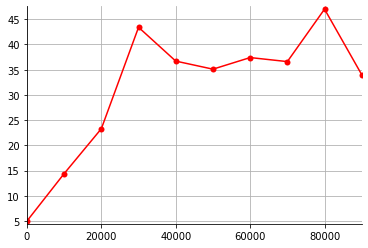

Reward 58
Reward 38
Reward 15
Reward 12
Reward 75
Reward 32
Reward 45
Reward 45
Reward 15
Reward 49


In [0]:
mdp.TabularQ = TabularQ
mdp.Q_learn = Q_learn
importlib.reload(code_for_hw10)

# Test: Tabular Q-learn
code_for_hw10.test_learn_play(iters=100000, tabular=True, batch=False)

In [0]:
def tinyTerminal(s):
    return s==4
def tinyR(s, a):
    if s == 1: return 1
    elif s == 3: return 2
    else: return 0
def tinyTrans(s, a):
    if s == 0:
        if a == 'a':
            return DDist({1 : 0.9, 2 : 0.1})
        else:
            return DDist({1 : 0.1, 2 : 0.9})
    elif s == 1:
        return DDist({1 : 0.1, 0 : 0.9})
    elif s == 2:
        return DDist({2 : 0.1, 3 : 0.9})
    elif s == 3:
        return DDist({3 : 0.1, 0 : 0.5, 4 : 0.4})
    elif s == 4:
        return DDist({4 : 1.0})
      
def testQ():
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = TabularQ(tiny.states, tiny.actions)
    qf = Q_learn(tiny, q)
    ret = list(qf.q.items())
    expected = [((0, 'a'), 0.6649739221724159), ((0, 'b'), 0.1712369526453748), 
                ((1, 'a'), 0.7732751316011999), ((1, 'b'), 1.2034912054227331), 
                ((2, 'a'), 0.37197205380133874), ((2, 'b'), 0.45929063274463033), 
                ((3, 'a'), 1.5156163024818292), ((3, 'b'), 0.8776852768653631), 
                ((4, 'a'), 0.0), ((4, 'b'), 0.0)]
    ok = True
    for (s,a), v in expected:
      qv = qf.get(s,a)
      if abs(qv-v) > 1.0e-5:
        print("Oops!  For (s=%s, a=%s) expected %s, but got %s" % (s, a, v, qv))
        ok = False
    if ok:
      print("Tests passed!")

random.seed(0)
testQ()      

Tests passed!


## 2.3) Batch Q_learn

In `Q_learn`, we made **one transition** <tt>(s,a,r,s')</tt>, computed a target Q value $t$ and updated the corresponding <tt>Q(s,a)</tt> estimate, every iteration. 

Now, we will implement `Q_learn_batch` which in each iteration, will generate **several such transitions** and update several <tt>Q(s,a)</tt> estimates correspondignly. 

Let's define an "episode" in the MDP as a full cycle of transitions, starting from first randomly picked start state $s_0$ to the terminal state which ends that "episode" of exploration. For example, in an episode of length 3, we perform 3 actions, yielding the following sequence of tuples: <tt>[(s_0,a_0,r_0,s_1), (s_1,a_1,r_1,s_2), (s_2,a_2,r_2,s_3)]</tt>.

So concretely, in every iteration of `Q_learn_batch`, we generate `n_episodes` new "episodes" using the current Q values for picking actions through our `epsilon_greedy` method. We then perform a batched update of the Q
values based on all the accumulated <tt>(s,a,r,s')</tt> tuples, and their corresponding target <tt>t</tt> values.

One last detail about our implementation is that in each iteration, **we will also use <tt>(s,a,r,s')</tt> tuples gathered from previous iterations to update Q values**. Notice that regardless of the iteration in which a <tt>(s,a,r,s')</tt> tuple was generated, it will always be representative of the dynamics of the MDP which we are exploring. So these tuples can be re-used across iterations of `Q_learn_batch` to make each iteration's Q value updates more informative.

**Note though,** that as Q values change every iteration, the target Q value <tt>t</tt> which goes with a certain <tt>(s,a,r,s')</tt> tuple in one iteration, will probably need to change when that same <tt>(s,a,r,s')</tt> tuple is re-used in another iteration. Make sure you understand why.

Here's pseudocode for what `Q_learn_batch` should be doing:

<pre>
# all collected (s,a,r,s') tuples across all iterations, are accumulated in all_experiences
all_experiences = []

Loop over n_iterations of Q-learn_batch:
    
    ''' data generation '''
    for i in range(n_episodes):
        Generate an episode (a sequence of (s,a,r,s') tuples) of length episode_length
	Add all experience (s,a,r,s') tuples from this episode to all_experiences list
    
    ''' update Q values - compute fresh targets for EVERY experience tuple'''
    all_q_targets = []
    
    For each (s,a,r,s') tuple from all_experiences list:
        Append (s,a,t) tuple to all_q_targets list, where t is the new Q target
        Remember to handle terminal states (where s' = None)
    
    q.update(all_q_targets, lr)

# return q so that the Tutor can test it
return q
</pre>


**The `sim_episode` method provided  will be useful and you can find the method definition in the next code block below:**

* `sim_episode` takes in an `mdp`, `episode_length` a `policy`, and a boolean `draw` as inputs, and it simulates an episode (sequence of transitions) in the provided `mdp`, of at most `episode_length`, using the `policy` function to select actions. If it finds a terminal state, it ends the episode.
* It returns the accumulated `reward` followed by an `episode` i.e. a list of <tt>(s, a, r, s')</tt> tuples, where s' is `None` for any transition from a terminal state.
* If `draw=True` is provided to `sim_episode`, its last returned object will be an animation, otherwise it will simply be `None`.

**Note that you should return `q`** so that the Tutor can test it.


In [0]:
# evaluate this cell so you can use the definition in your code below

def sim_episode(mdp, episode_length, policy, draw=False):
    '''
    Simulate an episode (sequence of transitions) of at most
    episode_length, using policy function to select actions.  If we find
    a terminal state, end the episode.  Return accumulated reward a list
    of (s, a, r, s') where s' is None for transition from terminal state.
    Also return an animation if draw=True, or None if draw=False
    '''
    episode = []
    reward = 0
    s = mdp.init_state()
    all_states = [s]
    for i in range(episode_length):
        a = policy(s)
        (r, s_prime) = mdp.sim_transition(s, a)
        reward += r
        if mdp.terminal(s):
            episode.append((s, a, r, None))
            break
        episode.append((s, a, r, s_prime))
        if draw: 
            mdp.draw_state(s)
        s = s_prime
        all_states.append(s)
    animation = animate(all_states, mdp.n, episode_length) if draw else None
    return reward, episode, animation

In [0]:
def Q_learn_batch(mdp, q, lr=.1, iters=100, eps=0.5,
                  episode_length=10, n_episodes=2,
                  interactive_fn=None):
    all_experiences = [] 
  
    for i in range(iters):
        # Your code also here
        # include this line in the iteration, where i is the iteration number
        if interactive_fn: interactive_fn(q, i)
        
        for j in range(n_episodes):
            reward, episode, animation = sim_episode(mdp, episode_length ,lambda s: epsilon_greedy(q,s,eps=0.5) , draw=False) 
            for elt in episode:
                all_experiences.append(elt)
        all_target_list = []
        for s,a,r,s_prime in all_experiences:
            if not mdp.terminal(s):
                t = r + mdp.discount_factor*value(q,s_prime)
            else:
                t = r 
            all_target_list.append((s,a,t))
        q.update(all_target_list,lr)
    return q

Run the next code blocks to test your implementation of `Q_learn_batch`.

,,,,,,,,,


score (0, 11.2)
score (1, 6.0)
score (2, 8.3)
score (3, 8.3)
score (4, 6.3)
score (5, 7.9)
score (6, 11.0)
score (7, 15.6)
score (8, 17.9)
score (9, 12.9)
String to upload (incude quotes): "286c70300a4930310a614930310a61286c70310a284c304c0a4631312e320a7470320a61284c314c0a46362e300a7470330a61284c324c0a46382e330a7470340a61284c334c0a46382e330a7470350a61284c344c0a46362e330a7470360a61284c354c0a46372e390a7470370a61284c364c0a4631312e300a7470380a61284c374c0a4631352e360a7470390a61284c384c0a4631372e390a747031300a61284c394c0a4631322e390a747031310a61612e"


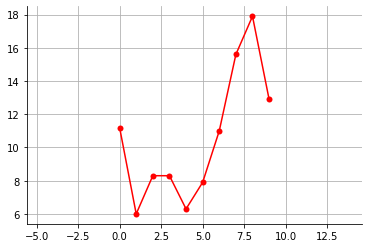

Reward 15
Reward 10
Reward 32
Reward 8
Reward 5
Reward 18
Reward 5
Reward 5
Reward 5
Reward 15


In [0]:
mdp.Q_learn_batch = Q_learn_batch
importlib.reload(code_for_hw10)

# Test: Tabular Batch Q-learn
code_for_hw10.test_learn_play(iters=10, tabular=True, batch=True) # Check: why do we want fewer iterations here?

In [0]:
def testBatchQ():
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = TabularQ(tiny.states, tiny.actions)
    qf = Q_learn_batch(tiny, q)
    ret = list(qf.q.items())
    expected = [((0, 'a'), 4.7566600197286535), ((0, 'b'), 3.993296047838986), 
                ((1, 'a'), 5.292467934685342), ((1, 'b'), 5.364014782870985), 
                ((2, 'a'), 4.139537149779127), ((2, 'b'), 4.155347555640753), 
                ((3, 'a'), 4.076532544818926), ((3, 'b'), 4.551442974149778), 
                ((4, 'a'), 0.0), ((4, 'b'), 0.0)]

    ok = True
    for (s,a), v in expected:
      qv = qf.get(s,a)
      if abs(qv-v) > 1.0e-5:
        print("Oops!  For (s=%s, a=%s) expected %s, but got %s" % (s, a, v, qv))
        ok = False
    if ok:
      print("Tests passed!")
      
      return list(qf.q.items())

random.seed(0)
testBatchQ()

Tests passed!


[((0, 'a'), 4.7566600197286535),
 ((0, 'b'), 3.993296047838986),
 ((1, 'a'), 5.292467934685342),
 ((1, 'b'), 5.364014782870985),
 ((2, 'a'), 4.139537149779127),
 ((2, 'b'), 4.155347555640753),
 ((3, 'a'), 4.076532544818926),
 ((3, 'b'), 4.551442974149778),
 ((4, 'a'), 0.0),
 ((4, 'b'), 0.0)]

# 3) NN Q: Using neural networks to store the Q function

We would like to operate in large or continuous state and/or action
spaces so it is not possible (or effective) to store the $Q$ values in
a table as we did with the <tt>TabularQ</tt> class; instead, we will
"store" them by training a neural network to do regression for us,
taking $s,a$ as input and generating (an approximation of) $Q^*(s,a)$
as output.

To train the network, we will use <i>squared Bellman error</i> as
the loss function:
$$\left(\left[R(s_t, a_t) + \gamma \max_{a'} Q(s_{t+1}, a'; \theta)\right]
- Q(s_t, a_t;\theta) \right)^2$$
where $\theta$ stands for the current weights in the neural network
and $Q(s, a; \theta)$ stands for the output of the network with
weights $\theta$ when $(s,a)$ is the input.

There are many choices of neural network architecture for storing Q
values.  In this problem, we will:

<ul>

<li> Focus on the case where we have a small set of possible actions,
so make one neural network for each possible action <math>a</math>;

<li> Design that network with two <b>hidden</b> layers with ReLU units
and a single linear output unit (although a deeper network could be
useful); and

<li> Use mean squared error (MSE) as the loss function since, we are
predicting continuous <math>Q</math> values, which is a regression
problem.

</ul>

To use a neural net to store Q values, for a given action, we will
need to have a mapping from states to fixed-length vectors.  We will
assume that the <code>MDP</code> class has a <code>state2vec</code>
method that maps states to vectors.  For the simple discrete-state
MDPs we have seen so far, this simply returns a one-hot representation
of the state. 

For reference, this is our implementation of
<code>state2vec</code> (note the shape of its returned array):
<pre>
    def state2vec(self, s):
        '''
        Return one-hot encoding of state s; used in neural network agent implementations
        '''
        v = np.zeros((1, len(self.states)))
        v[0,self.states.index(s)] = 1.
        return v
</pre>

Now, all we need to do is write a new class, called <code>NNQ</code>
to implement neural-network version of Q-function storage; then we can
pass an <code>NNQ</code> instance instead of a <code>TabularQ</code> instance
into <code>Q_learn</code> or <code>Q_learn_batch</code>, and
we will automatically have reinforcement learning with neural
networks!

There are three methods to implement in our <code>NNQ</code>
class. Here are some ideas for how to do that:
<ul>

<li> <code>__init__</code>: Create one neural network for each action,
and store them in <tt>self.models</tt>. Note that <tt>actions</tt> is
a list that may consist of integers or strings or other objects.  As a
reminder, here's how to make a new feed-forward network using PyTorch:


In [0]:
# please evaluate this cell so you can use it in your code
import torch
from torch import nn
def make_nn(state_dim, num_hidden_layers, num_units):
    print ('Making network', state_dim, num_hidden_layers, num_units)
    '''

    state_dim =	(int) number of states
    num_hidden_layers =	(int) number of	fully connected hidden layers
    num_units =	(int) number of	dense relu units to use	in hidden layers
    '''  
    model = []
    model += [nn.Linear(state_dim, num_units), nn.ReLU()]
    for i in range(num_hidden_layers-1):
        model += [nn.Linear(num_units, num_units), nn.ReLU()]
    model += [nn.Linear(num_units, 1)]
    model = nn.Sequential(*model)
    def init_weights(w):
      if type(w) == nn.Linear: nn.init.xavier_normal_(w.weight)
    print('Model: ', model)
    return model

<ul>
<li> <code>get(self, s, a)</code>: Use the neural network you have
stored for action <code>a</code> to predict a Q value for state
<code>s</code>. Feel free to consult a list of relevant
<a href="https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-custom-nn-modules">PyTorch code examples</a>
.</li>

<li> <code>update(self, data, lr, epochs = 1)</code>: As in
<code>TabularQ</code>, <code>data</code> is a list of <code>(s, a,t)</code>
tuples, where <code>t</code> is a target Q value.  For each
action <code>a</code>, you will need to:

  <ul>
  <li> Construct a training set <code>X, Y</code> of data that is
  relevant to action <code>a</code>, where the input values are states
  (encoded as vectors) and the output values are the target Q values;</li>

  <li> Use the provided method <code>fit(self, model, X, Y, epochs=epochs)</code>
  to update the weights in the associated network. </li>
  </ul>
</li>
</ul>

In [0]:
# Complete the following definition to implement the NNQ class
class NNQ:
    def __init__(self, states, actions, state2vec, num_layers, num_units,
                 lr=1e-2, epochs=1):
        self.running_loss = 0. # To keep a running average of the loss
        self.running_one = 0. # idem
        self.num_running = 0.001 # idem
        self.lr = lr
        self.actions = actions
        self.states = states
        self.state2vec = state2vec
        self.epochs = epochs
        state_dim = state2vec(states[0]).shape[1] # a row vector
        self.models = {a: make_nn(state_dim, num_layers, num_units) for a in self.actions}
    def predict(self, model, s):
      return model(torch.FloatTensor(self.state2vec(s))).detach().numpy()
    def get(self, s, a):
        return self.predict(self.models[a],s)
    def fit(self, model, X,Y, epochs=None, dbg=None):
      # This function receives two numpy arrays (with shape (K,7) and (K,1)), not two lists!
      assert type(X) is not type([]), "self.fit receives two numpy arrays (with shape (K,7) and (K,1)), not two lists!"
      if epochs is None: epochs = self.epochs
      train = torch.utils.data.TensorDataset(torch.FloatTensor(X), torch.FloatTensor(Y))
      train_loader = torch.utils.data.DataLoader(train, batch_size=256,shuffle=True)
      opt = torch.optim.SGD(model.parameters(), lr=self.lr)
      for epoch in range(epochs):
        for (X,Y) in train_loader:
          opt.zero_grad()
          loss = torch.nn.MSELoss()(model(X), Y)
          loss.backward()
          self.running_loss = self.running_loss*(1.-self.num_running) + loss.item()*self.num_running
          self.running_one = self.running_one*(1.-self.num_running) + self.num_running
          opt.step()
      if dbg is True or (dbg is None and np.random.rand()< (0.001*X.shape[0])):
        print('Loss running average: ', self.running_loss/self.running_one)

    def update(self, data, lr, dbg=None):
        # Your code here: train the model for every action
        # Remember to check there is actually data to train on!
        big_dict = {} #each action mapping to the numpy array of state and target value 
        if len(data)!=0:
            for s,a,t in data:
                if a in big_dict:
                    big_dict[a][0]= np.vstack((big_dict[a][0],self.state2vec(s)))
                    #v = big_dict[a][1][0,0] + self.lr*(t-big_dict[a][1][0,0])
                    big_dict[a][1]= np.vstack((big_dict[a][1],t))
                else:
                    #v = self.lr*t
                    big_dict[a]=[self.state2vec(s),t] 
            for a in big_dict:
                X, Y = big_dict[a][0], big_dict[a][1] 
                self.fit(self.models[a],X,Y,epochs= self.epochs)




 
Run the next code blocks to test your implementation of `NNQ`:

In [0]:
def test_NNQ(data):
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = NNQ(tiny.states, tiny.actions, tiny.state2vec, 2, 10)
    q.update(data, 1)
    ret =  [q.get(s,a) for s in q.states for a in q.actions]
    expect = [np.array([[-0.07211456]]), np.array([[-0.19553234]]), 
              np.array([[-0.21926211]]), np.array([[0.01699455]]), 
              np.array([[-0.26390356]]), np.array([[0.06374809]]), 
              np.array([[0.0340214]]), np.array([[-0.18334733]]), 
              np.array([[-0.438375]]), np.array([[-0.13844737]])]
    cnt = 0
    ok = True
    for s in q.states:
      for a in q.actions:
        if not np.all(np.abs(ret[cnt]-expect[cnt]) < 1.0e0):
          print("Oops, for s=%s, a=%s expected %s but got %s" % (s, a, expect[cnt], ret[cnt]))
          ok = False
        cnt += 1
    if ok:
      print("Output looks generally ok")
    return [q.get(s,a).item(0) for s in q.states for a in q.actions]
  
print(test_NNQ([(0,'a',0.3),(1,'a',0.1),(0,'a',0.1),(1,'a',0.5)]))

Making network 5 2 10
Model:  Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)
Making network 5 2 10
Model:  Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)
Output looks generally ok
[-0.32190045714378357, 0.36648795008659363, -0.3583308458328247, 0.37070220708847046, -0.30701401829719543, 0.34057119488716125, -0.3384156823158264, 0.3958413004875183, -0.3586074709892273, 0.33182379603385925]


In [0]:
print(test_NNQ([(0,'a',0.3),(1,'a',0.1),(0,'a',0.1),(1,'a',0.5)]))

Making network 5 2 10
Model:  Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)
Making network 5 2 10
Model:  Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)
Output looks generally ok
[-0.12967011332511902, -0.463051974773407, -0.12740060687065125, -0.4686024785041809, -0.17825259268283844, -0.4422762989997864, -0.1301695704460144, -0.4397754967212677, -0.08712989091873169, -0.5053134560585022]


In [0]:
def tinyTrans2(s, a):
    if s == 0:
        return DDist({1 : 1.0})
    elif s == 1:
        return DDist({2 : 1.0})
    elif s == 2:
        return DDist({3 : 1.0})
    elif s == 3:
        return DDist({4 : 1.0})
    elif s == 4:
        return DDist({4 : 1.0})

def test_NNQ2(data):
    np.random.seed(0)
    torch.manual_seed(0)
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans2, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = NNQ(tiny.states, tiny.actions, tiny.state2vec, 2, 10)
    q.update(data, 1)
    return [q.get(s,a).item(0) for s in q.states for a in q.actions]
  
print(test_NNQ2([(0,'a',0.3),(1,'a',0.1),(0,'a',0.1),(1,'a',0.5)]))

Making network 5 2 10
Model:  Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)
Making network 5 2 10
Model:  Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)
[0.07894802838563919, -0.2069215178489685, 0.0800420492887497, -0.16860328614711761, 0.0936352014541626, -0.19312028586864471, 0.06085893511772156, -0.24304574728012085, 0.04742565006017685, -0.26113754510879517]


 **The unbatched version of `NNQ` is pretty unstable, you may thus have to lower the learning rate of the optimizer.** To decide whether to change the learning rate, observe if the loss diverges.

In [0]:
mdp.NNQ = NNQ
importlib.reload(code_for_hw10)

# Test: NN Q-learn
code_for_hw10.test_learn_play(nnq_lr=1e-2, iters=100000, tabular=False, batch=False)

## 3.2) Fitted Q iteration

*Fitted Q iteration (FQ)* suffers less from the correlated experience problem and is generally more stable (and sometimes slower) than NNQ. **You can therefore use a 2-10x higher learning rate than the unbatched version, which should speed results.**

FQ initializes the Q networks and an empty data set, then operates in a loop:

1. Use *ϵ*-greedy exploration to generate *k* steps of experience, of the form *(s,a,r,s′)* and add them to the data set.
2. Create one training set for each action *a*:

> 1. Extract all the tuples from your data set that contain action *a*,
> 2. Let the *X* values of your training set be all of the *s* values from your data tuples with action *a* and the *Y* values be the *r + γ max_a' Q(s', a')* values computed for each data tuple, using the Q estimates from the current network.

3. Train the network for action *a* for several epochs until it has done a good job of representing this data.

So, this is basically `Q_learn_batch` using `NNQ` (training with multiple epochs) to implement the Q function.

Run the next code block to test your implementation of `NNQ` with batching.

Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
score (0, 5.0)
Loss running average:  0.44504184650296796
Loss running average:  0.4716872776445042
score (5, 8.3)
Loss running average:  0.5593933347586549
Loss running average:  0.5816760596935537
score (10, 5.0)
Loss running average:  0.6014598793882

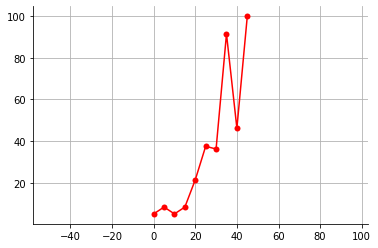

Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100


In [0]:
# Test: NN Batch Q-learn (Fitted Q-learn)
code_for_hw10.test_learn_play(nnq_lr=1e-2, iters=50, tabular=False, batch=True)

#4) No Exit

Please read the instructions in the [homework](https://lms.mitx.mit.edu/courses/course-v1:MITx+6.036+2019_Spring/courseware/Week10/week10_homework/) to set up for the game. You may use this space to display the game in Colab.

For each of the learning method and Q model combinations below,
solve the game so that it reliably gets to reward of 100 (that is, the
learned game reliably plays 100 steps without missing the ball,
earning a score of 100).  During learning, you should see a sequence
of lines like: <code>score (5000, 37.5)</code>, which indicates that
after 5000 iterations the average reward over 10 games is 37.5.  We
are checking whether you reach a solution that gets an average reward
100 at least one time. Try playing around with the number of
iterations (an argument to <code>test_learn_play</code>) until you
achieve this point. Note that we will need fewer iterations for
Q_learn_batch, in general (check yourself: why?). After learning, the
code prints a long "upload string" in HEX code.  Enter the upload
strings in the question boxes in the homework MITx site.

In [0]:
# Value Iteration
code_for_hw10.test_solve_play(draw = True)

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward 100


<Figure size 432x288 with 0 Axes>

score (0, 8.0)
score (40000, 44.4)
score (80000, 30.6)
score (120000, 42.1)
score (160000, 44.8)
score (200000, 100.0)
score (240000, 100.0)
score (280000, 100.0)
score (320000, 100.0)
score (360000, 100.0)
String to upload (incude quotes): "286c70300a4930310a614930300a61286c70310a284c304c0a46382e300a7470320a61284c34303030304c0a4634342e340a7470330a61284c38303030304c0a4633302e360a7470340a61284c3132303030304c0a4634322e310a7470350a61284c3136303030304c0a4634342e380a7470360a61284c3230303030304c0a463130302e300a7470370a61284c3234303030304c0a463130302e300a7470380a61284c3238303030304c0a463130302e300a7470390a61284c3332303030304c0a463130302e300a747031300a61284c3336303030304c0a463130302e300a747031310a61612e"


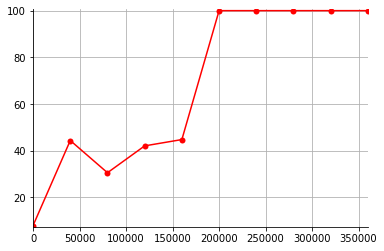

WidgetException: ignored

In [0]:
# Tabular Q-learn
code_for_hw10.test_learn_play(draw=True, iters=400000, tabular=True, batch=False)

score (0, 5.3)
score (15, 37.5)
score (30, 37.8)
score (45, 40.7)
score (60, 39.2)
score (75, 63.1)
score (90, 100.0)
score (105, 100.0)
score (120, 100.0)
score (135, 92.0)
String to upload (incude quotes): "286c70300a4930310a614930310a61286c70310a284c304c0a46352e330a7470320a61284c31354c0a4633372e350a7470330a61284c33304c0a4633372e380a7470340a61284c34354c0a4634302e370a7470350a61284c36304c0a4633392e320a7470360a61284c37354c0a4636332e310a7470370a61284c39304c0a463130302e300a7470380a61284c3130354c0a463130302e300a7470390a61284c3132304c0a463130302e300a747031300a61284c3133354c0a4639322e300a747031310a61612e"


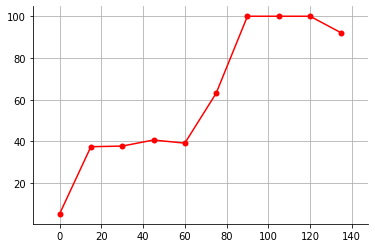

WidgetException: ignored

In [0]:
# Tabular Batch Q-learn
code_for_hw10.test_learn_play(draw=True, iters=150, tabular=True, batch=True) # Check: why do we want fewer iterations here?

Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
score (0, 11.2)
Loss running average:  0.0026849123980887484
Loss running average:  0.002286118257602672
Loss running average:  0.0016534227241531108
Loss running average:  0.001318340746330551
Loss running average:  0.0010957771049742203
Loss running a

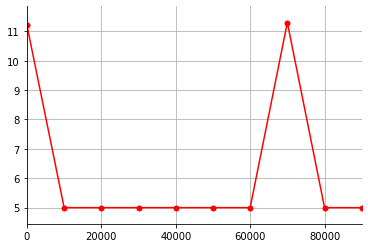

Reward 5


<Figure size 432x288 with 0 Axes>

Reward 5


<Figure size 432x288 with 0 Axes>

Reward 5


<Figure size 432x288 with 0 Axes>

Reward 5


<Figure size 432x288 with 0 Axes>

Reward 5


<Figure size 432x288 with 0 Axes>

Reward 55


<Figure size 432x288 with 0 Axes>

Reward 5


<Figure size 432x288 with 0 Axes>

Reward 5


<Figure size 432x288 with 0 Axes>

Reward 5


<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward 5


<Figure size 432x288 with 0 Axes>

In [0]:
# NN Q-learn
code_for_hw10.test_learn_play(draw=True, iters=100000, tabular=False, batch=False)

Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
Making network 7 2 100
Model:  Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
)
score (0, 5.0)
Loss running average:  0.614620437196386
Loss running average:  0.6138918848577828
Loss running average:  0.6745305671556939
Loss running average:  0.6941606261118839
score (10, 12.3)
Loss running average:  0.7265192111568708
Loss running

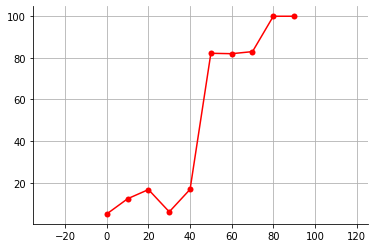

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

Reward 100


<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward 100


<Figure size 432x288 with 0 Axes>

In [0]:
# NN Batch Q-learn (Fitted Q-learn)
code_for_hw10.test_learn_play(draw=True, iters=100, tabular=False, batch=True)